# ml

> Machine Learning Utility Functions

In [ ]:
#| default_exp ml

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor, CatBoostClassifier
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from scipy.stats import mannwhitneyu
import seaborn as sns
import shap
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors._base import _get_weights
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import TimeSeriesSplit
import copy
from scipy.special import inv_boxcox1p, boxcox1p
from sklearn.preprocessing import PowerTransformer

class RegressorTimeSeriesCV(BaseEstimator, RegressorMixin):
    def __init__(self, base_reg, cv=5, verbose=False, catboost_use_eval_set=False, add_box_cox_target=False):
        """
        Train a base regressor using timeseries cross-validation and also record metrics.
        Parameters
        ----------
        base_reg : estimator object implementing 'fit'
            The object to use to fit the data.
        cv : int, default=5
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:
            - int, to specify the number of folds in a `KFold`,
        verbose : bool, default=False
            Wheter or not to print metrics
        catboost_use_eval_set : bool, default=False
            Whether or not to use eval_set in CatBoostRegressor
        """
        # Parameters
        self.cv = cv
        self.base_reg = base_reg
        self.verbose = verbose
        self.catboost_use_eval_set = catboost_use_eval_set
        self.add_box_cox_target=add_box_cox_target

        # Internal Parameters
        self._tss = TimeSeriesSplit(n_splits=cv)

        # Attributes
        self.cv_results_ = []
        self.metrics_ = None
        self.y_test_last_fold_ = None
        self.y_pred_last_fold_ = None
            

    def fit(self, X, y, sample_weight=None):
        if self.add_box_cox_target:
            pt = PowerTransformer(method="box-cox")
            #y = pd.Series(np.where(y==0, np.nan, y))
            pt.fit(y.to_frame())
            self.lmda = pt.lambdas_[0]
            y = boxcox1p(y, self.lmda)
        
        ts_split = self._tss.split(X)

        # Loop over train/test subsets
        for fold_n, (train_index, test_index) in enumerate(ts_split):
            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            else:
                X_train, X_test = X[train_index], X[test_index]

            if isinstance(y, pd.Series):
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif isinstance(y, pd.DataFrame):
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                y_train, y_test = y[train_index], y[test_index]
            
            # Apply weights for current fold if sample_weight is not None
            if sample_weight is not None:
                if isinstance(sample_weight, pd.Series):
                    sample_weight_train = sample_weight.iloc[train_index]
                elif isinstance(sample_weight, pd.DataFrame):
                    sample_weight_train = sample_weight.iloc[train_index]
                else: # Assume it is a numpy array
                    sample_weight_train = sample_weight[train_index]
            else:
                sample_weight_train = None

            reg = copy.deepcopy(self.base_reg)
            # TODO: Fix 'to employ eval_set' error
            if self.catboost_use_eval_set:
                reg.fit(X_train, y_train, eval_set=(X_test, y_test), sample_weight=sample_weight_train)
            else:
                reg.fit(X_train, y_train, sample_weight=sample_weight_train)

            if self.verbose:
                print(f'Fold {fold_n} Results:')
                metrics, y_pred = self._get_reg_metrics(reg, X_test, y_test)
                print('-'*80)
            else:
                metrics, y_pred = self._get_reg_metrics(reg, X_test, y_test)
            
            self.cv_results_.append(
                {
                    'fold': fold_n,
                    'reg': reg,
                    'train_size': len(train_index),
                    'test_size': len(test_index),
                    'train_start_index': train_index[0],
                    'train_end_index': train_index[-1],
                    'test_start_index': test_index[0],
                    'test_end_index': test_index[-1],
                    'metrics': metrics
                }
            )
        # Store y_test and y_pred from last fold
        self.y_test_last_fold_ = y_test
        self.y_pred_last_fold_ = y_pred

        # Fit the base regressor on the full data
        if sample_weight is not None:
            if self.catboost_use_eval_set:
                self.base_reg.fit(X, y, sample_weight=sample_weight, eval_set=(X, y))
            else:
                self.base_reg.fit(X, y, sample_weight=sample_weight)
        else:
            if self.catboost_use_eval_set: 
                self.base_reg.fit(X, y, eval_set=(X, y))
            else:
                self.base_reg.fit(X, y)
            
        self._convert_report_to_df()
        self.metrics_ = self.get_metrics_summary()

        return self

 
    @staticmethod
    def _append_df(df, new_row):
        df = pd.concat([df, pd.DataFrame([new_row])])
        return df

    def get_metrics_summary(self):
        metrics = self.cv_results_
        metrics = metrics.drop(['reg'], axis=1).set_index('fold')
        metrics_mean = metrics.mean().rename('mean')
        metrics_std = metrics.std().rename('std')
        metrics = self._append_df(metrics, metrics_mean)
        metrics = self._append_df(metrics, metrics_std)
        int_cols = [
            'train_size', 'test_size', 'train_start_index', 'train_end_index', 'test_start_index', 
            'test_end_index'
        ]
        metrics[int_cols] = metrics[int_cols].astype(int)
        if self.verbose:
            print('Metrics')
            print(metrics)
        return metrics

    def predict(self, X):
        if self.add_box_cox_target:
            return inv_boxcox1p(self.base_reg.predict(X), self.lmda)
        return self.base_reg.predict(X)
    
    def _convert_report_to_df(self):
        self.cv_results_ = pd.DataFrame(self.cv_results_)
        m = pd.DataFrame(
            self.cv_results_.metrics.tolist(), columns=[
                'r2_score', 'rmse', 'mape'
            ]
        )

        self.cv_results_ = pd.concat([self.cv_results_, m], axis=1)
        self.cv_results_ = self.cv_results_.drop('metrics', axis=1)
    
    def _reg_metrics(self, y, y_pred):
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y, y_pred)
        if self.verbose:
            print('R2 Score:', r2)
            print('RMSE:', rmse)
            print('MAPE:', mape)
        
        return r2, rmse, mape

    def _get_reg_metrics(self, reg, X, y):
        # Reverse back y_pred if add_box_cox_target is True
        if self.add_box_cox_target:
            y = inv_boxcox1p(y, self.lmda)
            
        y_pred = reg.predict(X)
        if self.add_box_cox_target:
            y_pred = inv_boxcox1p(y_pred, self.lmda)

        r2, rmse, mape = self._reg_metrics(y, y_pred)

        return (r2, rmse, mape), y_pred


class RegressorCV(BaseEstimator, RegressorMixin):
    def __init__(self, base_reg, cv=5, groups=None, verbose=False, n_bins_stratify=None, add_box_cox_target=False):
        """
        Trains an estimator using cross-validation and records metrics for each fold. Also stores
        each model that is trained on each fold of the cross-validation process. The final 
        prediction is made as the median value of the predictions from each stored model.

        Parameters
        ----------
        base_reg : estimator object implementing 'fit'
            The object to use to fit the data.
        cv : int or cross-validation generator, default=5
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:
            - int, to specify the number of folds in a `KFold`,
            - `CV splitter`, i.e., a sklearn class object to split a dataset 
            into train/test set
        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples used while splitting the dataset into
            train/test set. If cv is an integer, a `GroupKFold` object is going
            to be declared.
        n_bins_stratify : int, default=None
            Number of bins to use for stratification. If cv is an integer, a
            `StratifiedKFold` object is going to be declared. If groups is
            declared, it will be used instead of n_bins_stratify.
        verbose : bool, default=False
            Wheter or not to print metrics"""
        # Parameters
        self.cv = cv
        self.base_reg = base_reg
        self.verbose = verbose
        self.groups = groups
        self.n_bins_stratify = n_bins_stratify
        self.add_box_cox_target=add_box_cox_target

        # Internal Parameters
        if isinstance(cv, int): # Check if cv is an int instead of a CV object
            # Add groups if parameters was declared
            if groups is not None:
                self._kf = GroupKFold(n_splits=cv)
            # Add stratify if parameters was declared
            elif n_bins_stratify is not None:
                self._kf = StratifiedKFold(n_splits=cv)
            # Otherwise, use KFold
            else:
                self._kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        else:
            self._kf = cv # Assumes it is a CV Splitter

        # Attributes
        self.cv_results_ = {
            'fold': [],
            'reg': [], 
            'metrics': []
        }
        self.oof_train_ = None
        self.oof_score_ = None
        self.oof_mape_ = None
        self.oof_rmse_ = None
        self.metrics_ = None

        
    def fit(self, X, y, **kwargs):
        # Apply transformation here if True
        if self.add_box_cox_target:
            pt = PowerTransformer(method="box-cox")
            #y = pd.Series(np.where(y==0, np.nan, y))
            pt.fit(y.to_frame())
            self.lmda = pt.lambdas_[0]
            y = boxcox1p(y, self.lmda)
            
        self.oof_train_ = pd.Series(index=y.index, dtype='float64')

        # Check if groups is declared
        if self.groups is not None:
            kf_split = self._kf.split(X, groups=self.groups)
        elif self.n_bins_stratify is not None:
            y_bin = pd.cut(y, self.n_bins_stratify, labels=False)
            kf_split = self._kf.split(X, y_bin)
            if self.verbose:
                print('Stratifying')
                print(y_bin.value_counts().sort_index())
                print(y_bin.value_counts(normalize=True).sort_index())
                print('-'*80)

        else:
            kf_split = self._kf.split(X)

        # Loop over train/test subsets
        for fold_n, (train_index, test_index) in enumerate(kf_split):
            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            else:
                X_train, X_test = X[train_index], X[test_index]

            if isinstance(y, pd.Series):
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif isinstance(y, pd.DataFrame):
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                y_train, y_test = y[train_index], y[test_index]
            
            if self.verbose:
                # Check if stratification is consistent
                if self.n_bins_stratify is not None:
                    y_train_bin = y_bin.iloc[train_index]
                    y_test_bin = y_bin.iloc[test_index]
                    print('Training set stratification')
                    print(y_train_bin.value_counts().sort_index())
                    print(y_train_bin.value_counts(normalize=True).sort_index())
                    print('Testing set stratification')
                    print(y_test_bin.value_counts().sort_index())
                    print(y_test_bin.value_counts(normalize=True).sort_index())
                    print('-'*80)
                else:
                    y_train_bin = pd.cut(y_train, 10)
                    y_test_bin = pd.cut(y_test, 10)
                    print('Training set no stratification')
                    print(y_train_bin.value_counts().sort_index())
                    print(y_train_bin.value_counts(normalize=True).sort_index())
                    print('Testing set no stratification')
                    print(y_test_bin.value_counts().sort_index())
                    print(y_test_bin.value_counts(normalize=True).sort_index())
                    print('-'*80)
            reg = copy.deepcopy(self.base_reg)
            reg.fit(X_train, y_train, **kwargs)
            if self.verbose:
                print(f'Fold {fold_n} Results:')
                metrics, y_pred = self._get_reg_metrics(reg, X_test, y_test)
                print('-'*80)
            else:
                metrics, y_pred = self._get_reg_metrics(reg, X_test, y_test)

            if len(y_pred.shape)==1:
                self.oof_train_.iloc[test_index] = y_pred
            if len(y_pred.shape)==2: # handle extra dimension that happens when y is a DataFrame
                y_pred = y_pred.squeeze()
                self.oof_train_.iloc[test_index] = y_pred

            self.cv_results_['fold'].append(fold_n)
            self.cv_results_['reg'].append(reg)
            self.cv_results_['metrics'].append(metrics)
        self._convert_report_to_df()
        # TODO: Reverse back if add_box_cox_target is True
        if self.add_box_cox_target:
            # self.oof_train_ = inv_boxcox1p(self.oof_train_, self.lmda)
            y = inv_boxcox1p(y, self.lmda)
        
        self.oof_score_ = r2_score(y, self.oof_train_)
        self.oof_mape_ = mean_absolute_percentage_error(y, self.oof_train_)
        self.oof_rmse_ = mean_squared_error(y, self.oof_train_, squared=False)
        self.metrics_ = self.get_metrics_summary()

        return self
    
    @staticmethod
    def _append_df(df, new_row):
        df = pd.concat([df, pd.DataFrame([new_row])])
        return df

    def get_metrics_summary(self):
        metrics = self.cv_results_
        metrics = metrics.drop('reg', axis=1)
        metrics = metrics.set_index('fold')
        metrics_mean = metrics.mean().rename('mean')
        metrics_std = metrics.std().rename('std')
        metrics = self._append_df(metrics, metrics_mean)
        metrics = self._append_df(metrics, metrics_std)
        oof_score = self.oof_score_
        oof_mape = self.oof_mape_
        if self.verbose:
            print('Metrics')
            print(metrics)
            print('CV R2 Score (OOF):', oof_score)
            print('CV MAPE (OOF):', oof_mape)
        return metrics

    def predict(self, X):
        y_preds = []
        for reg in self.cv_results_.reg.values:
            y_preds.append(reg.predict(X))

        y_pred = np.median(y_preds, axis=0)
        
        # Reverse y_pred here if add_box_cox_target is true
        if self.add_box_cox_target:
            y_pred = inv_boxcox1p(y_pred, self.lmda)
        return y_pred
    
    def _convert_report_to_df(self):
        self.cv_results_ = pd.DataFrame(self.cv_results_)
        m = pd.DataFrame(
            self.cv_results_.metrics.tolist(), columns=[
                'r2_score', 'rmse', 'mape'
            ]
        )

        self.cv_results_ = pd.concat([self.cv_results_, m], axis=1)
        self.cv_results_ = self.cv_results_.drop('metrics', axis=1)
    
    def _reg_metrics(self, y, y_pred):
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y, y_pred)
        if self.verbose:
            print('R2 Score:', r2)
            print('RMSE:', rmse)
            print('MAPE:', mape)
        
        return r2, rmse, mape

    def _get_reg_metrics(self, reg, X, y):
        # TODO: Reverse back y_pred if add_box_cox_target is True
        if self.add_box_cox_target:
            y = inv_boxcox1p(y, self.lmda)
        
        y_pred = reg.predict(X)
        if self.add_box_cox_target:
            y_pred = inv_boxcox1p(y_pred, self.lmda)

        r2, rmse, mape = self._reg_metrics(y, y_pred)

        return (r2, rmse, mape), y_pred

class CatBoostRegressorCV(RegressorCV):
    def __init__(self, cv=5, cat_features=None, groups=None, verbose=False, n_bins_stratify=None, add_box_cox_target=False, **reg_args):
        self.cat_features = cat_features
        base_reg = CatBoostRegressor(
            verbose=0,
            cat_features=self.cat_features,
            **reg_args
        )
        super().__init__(
            cv=cv,
            base_reg=base_reg,
            groups=groups,
            verbose=verbose,
            n_bins_stratify=n_bins_stratify,
            add_box_cox_target = add_box_cox_target
        )

class KNNRegressor(KNeighborsRegressor):
    def predict(self, X, return_match_index=False, pred_calc='mean'):
        X = check_array(X, accept_sparse='csr')

        neigh_dist, neigh_ind = self.kneighbors(X)

        weights = _get_weights(neigh_dist, self.weights)

        _y = self._y
        if _y.ndim == 1:
            _y = _y.reshape((-1, 1))

        ######## Begin modification
        if weights is None:
            if pred_calc=='mean':
                y_pred = np.mean(_y[neigh_ind], axis=1)
            elif pred_calc=='median':
                y_pred = np.median(_y[neigh_ind], axis=1)
        else:
            #y_pred = weighted_median(_y[neigh_ind], weights, axis=1)
            #raise NotImplementedError("weighted median")
            y_pred = np.empty((neigh_dist.shape[0], _y.shape[1]), dtype=np.float64)
            denom = np.sum(weights, axis=1)

            for j in range(_y.shape[1]):
                num = np.sum(_y[neigh_ind, j] * weights, axis=1)
                y_pred[:, j] = num / denom
        ######### End modification

        if self._y.ndim == 1:
            y_pred = y_pred.ravel()

        if return_match_index:
            d = _y[neigh_ind]
            middle_idx = self.n_neighbors//2 #assumes n_neighbors is odd
            median_idx = np.argsort(d)[:, middle_idx]
            nearest_index = []
            for ni, mi in zip(neigh_ind, median_idx):
                nearest_index.append(ni[mi])

            nearest_matched_index = np.array(nearest_index)

            return y_pred, nearest_matched_index, neigh_ind
        else:
            return y_pred



class AutoRegressor:
    """
    AutoRegressor is a class for performing automated regression tasks, including preprocessing and model fitting.
    It supports several regression algorithms and allows for easy comparison of their performance on a given dataset.
    The class provides various methods for model evaluation, feature importance, and visualization.

    Example Usage:
        ar = AutoRegressor(num_cols, cat_cols, target_col, data)
        ar.fit_report()

    Parameters
    ----------
    num_cols : list
        List of numerical columns in the dataset.
    cat_cols : list
        List of categorical columns in the dataset.
    target_col : str
        Target column name in the dataset.
    data : pd.DataFrame, optional
        Input dataset (pandas DataFrame) containing both features and target column.
        If not provided, `train` and `test` datasets should be supplied. Default is None.
    train : pd.DataFrame, optional
        Training dataset (pandas DataFrame) containing both features and target column.
        Used if `data` is not provided. Default is None.
    test : pd.DataFrame, optional
        Testing dataset (pandas DataFrame) containing both features and target column.
        Used if `data` is not provided. Default is None.
    random_st : int, optional
        Random state for reproducibility. Default is 42.
    log_target : bool, optional
        Boolean flag to indicate if the logarithm of the target variable should be used.
        Default is False.
    estimator : str or estimator object, optional
        String or estimator object. Options are 'catboost', 'random_forest', and 'linear'.
        Default is 'catboost'.
    imputer_strategy : str, optional
        Imputation strategy for missing values. Options are 'simple' and 'knn'.
        Default is 'simple'.
    use_catboost_native_cat_features : bool, optional
        Boolean flag to indicate if the native CatBoost categorical feature handling should be used.
        Default is False.
    ohe_min_freq : float, optional
        Minimum frequency for OneHotEncoder to consider a category in categorical columns.
        Default is 0.05.
    scale_numeric_data : bool, optional
        Boolean flag to indicate if numeric data should be scaled using StandardScaler.
        Default is False.
    scale_categoric_data : bool, optional
        Boolean flag to indicate if categorical data (after one-hot encoding) should be scaled using StandardScaler.
        Default is False.
    """
    def __init__(
        self,
        num_cols, 
        cat_cols, 
        target_col,
        data=None,
        train=None,
        test=None,
        random_st=42, 
        log_target=False,
        estimator='catboost',
        imputer_strategy='simple',
        use_catboost_native_cat_features=False,
        ohe_min_freq=0.05,
        scale_numeric_data=False,
        scale_categoric_data=False,
        scale_target=False
):
        self.num_cols, self.cat_cols = num_cols, cat_cols
        self.estimator = estimator
        self.target_col = target_col
        self.imputer_strategy = imputer_strategy
        self.use_catboost_native_cat_features = use_catboost_native_cat_features
        self.ohe_min_freq = ohe_min_freq
        self.scale_numeric_data = scale_numeric_data
        self.scale_categoric_data = scale_categoric_data
        if data is not None:
            self.data = data.copy()

            if log_target:
                self.data['target'] = self.data[target_col].apply(np.log1p)
            else:
                self.data['target'] = self.data[target_col]

            self.data.drop(columns=target_col, inplace=True)

            self.train, self.test = train_test_split(
                self.data, random_state=random_st
            )
        else:
            self.train = train.copy()
            self.train['target'] = self.train[target_col]
            self.train.drop(columns=target_col, inplace=True)
            self.test = test.copy()
            self.test['target'] = self.test[target_col]
            self.test.drop(columns=target_col, inplace=True)
            self.data = pd.concat([train, test])
        
        if scale_target: # Use StandardScaler to scale target
            self.target_scaler = StandardScaler()
            self.train['target'] = self.target_scaler.fit_transform(
                self.train['target'].values.reshape(-1, 1)
            )
            self.test['target'] = self.target_scaler.transform(
                self.test['target'].values.reshape(-1, 1)
            )
        else:
            self.target_scaler = None


        self.prep = self.get_pipeline_preprocessor()

        if isinstance(estimator, str):
            if estimator=='random_forest':
                self.reg = RandomForestRegressor(random_state=random_st)
            elif estimator=='catboost':
                if self.use_catboost_native_cat_features:
                    self.reg = CatBoostRegressor(
                        verbose=0,
                        cat_features=list(range(len(cat_cols))) # Assuming cat features are coming first
                    )
                else:
                    self.reg = CatBoostRegressor(verbose=0)
            else:
                self.reg = LinearRegression()
        else:
            self.reg = estimator
        
        print('Using estimator', self.reg)
        
        self.model = self.get_model_pipeline(self.prep, self.reg)
    
    def fit_report(self):
        self.model.fit(self.train, self.train.target)
        print('R2 Score:', self.model.score(self.test, self.test.target))
        self.y_pred = self.model.predict(self.test)
        rmse = mean_squared_error(self.test.target, self.y_pred, squared=False)
        print('RMSE:', rmse)
        mape = mean_absolute_percentage_error(self.test.target, self.y_pred)
        print('MAPE:', mape)

    def _proc_output_names(self):
        model = self.model

        ct = model.steps[0][1]
        if self.use_catboost_native_cat_features:
            self.cat_out_names_ = self.cat_cols
        else:
            ct_cat = ct.transformers_[0][1]
            ct_cat_oh = ct_cat.steps[1][1]
            cat_out_names_ = list(ct_cat_oh.get_feature_names_out())

            for i, cat in enumerate(self.cat_cols):
                prefix = f'x{i}'
                for j, name in enumerate(cat_out_names_):
                    if prefix in name[:len(prefix)]:
                        cat_out_names_[j] = name.replace(prefix, cat)
            
            self.cat_out_names_ = cat_out_names_

        ct_num = ct.transformers_[1][1]
        ct_num_si = ct_num.steps[0][1]
        self.num_out_names_ = list(ct_num_si.feature_names_in_)

        return self.cat_out_names_ + self.num_out_names_
    
    def test_binary_column(self, binary_column):
        print('Significance test on', binary_column)
        filter_feature = self.data[binary_column]==1
        with_feature = self.data.loc[filter_feature, 'target'].values
        without_feature = self.data.loc[~filter_feature, 'target'].values
        sns.histplot(
            x="target", 
            hue=binary_column, 
            data=self.data,
            multiple="dodge",
            binwidth=1
            #element="step"
        ).set_title(
            'Distributions of binary feature'
        )
        plt.show()
        sns.boxplot(
            x=binary_column,
            y='target',
            data=self.data
        ).set_title(
            'Boxplot of binary feature'
        )
        plt.show()
        U1, p = mannwhitneyu(with_feature, without_feature, alternative='two-sided')
        print('Two-sided p-value for Mann–Whitney U test is', p)
        return p

    def get_coefficients(self):
        if self.estimator=='linear':
            output_names = self._proc_output_names()
            #coef = pd.DataFrame(
            #    self.reg.coef_,
            #    index=output_names
            #)

            coef = pd.DataFrame(
                {
                    'features': output_names,
                    'importance':self.clf.coef_
                }
            )

            sorted_idx = coef.apply(
                lambda x: abs(sum(x)), axis=1
            ).sort_values(ascending=False).index

            coef = coef.loc[sorted_idx]

            return coef
        elif self.estimator=='random_forest' or self.estimator=='catboost':
            output_names = self._proc_output_names()
            feat_imp = pd.DataFrame(
                {
                    'features': output_names,
                    'importance': self.reg.feature_importances_
                }   
            )

            feat_imp = feat_imp.sort_values(
                by='importance',
                ascending=False
            )

            return feat_imp


    def get_feature_importances(self):
        output_names = self._proc_output_names()
        feat_imp = pd.Series(
            self.reg.feature_importances_,
            index=output_names
        )

        feat_imp = feat_imp.sort_values(ascending=False)

        return feat_imp
    
    def get_shap(self, return_shap_values=False):
        explainer = shap.TreeExplainer(self.model['estimator'])
        observations = self.model['preprocessor'].transform(self.test)
        feature_names = self._proc_output_names()
        observations = pd.DataFrame(observations, columns=feature_names)
        shap_values = explainer(observations)
        shap.summary_plot(shap_values)
        if return_shap_values:
            return shap_values
    
    def plot_importance(
        self,
        feat_imp,
        graph_title="Model feature importance"
    ):
        sns.barplot(
            data=feat_imp,
            x='importance',
            y='features').set(title=graph_title)
        return

    def get_pipeline_preprocessor(self):
        
        if self.imputer_strategy=='knn':
            self.num_out_transformer = KNNImputer(n_neighbors=3)
        elif self.imputer_strategy=='simple':
            self.num_out_transformer = SimpleImputer(strategy='median')
        print('Imputer strategy:', self.num_out_transformer)

        if self.use_catboost_native_cat_features:
            cat_pipe = Pipeline(
                [
                    ('imputer', SimpleImputer(strategy='constant'))
                    #('scaler', StandardScaler())
                
                ]
            )
        else:
            if self.scale_categoric_data:
                cat_pipe = Pipeline(
                    [
                        ('imputer', SimpleImputer(strategy='constant')),
                        ('one_hot', OneHotEncoder(
                            sparse=False,
                            handle_unknown='infrequent_if_exist',
                            min_frequency=self.ohe_min_freq # ignore minority categories
                        )),
                        ('scaler', StandardScaler())
                    
                    ]
                )
            else:
                cat_pipe = Pipeline(
                    [
                        ('imputer', SimpleImputer(strategy='constant')),
                        ('one_hot', OneHotEncoder(
                            sparse=False,
                            handle_unknown='infrequent_if_exist',
                            min_frequency=self.ohe_min_freq # ignore minority categories
                        )),
                        #('scaler', StandardScaler())
                    
                    ]
                )
        if self.scale_numeric_data:
            num_pipe = Pipeline(
                [
                    ('imputer', self.num_out_transformer),
                    ('scaler', StandardScaler()) # Needed for coeff outputting Z-Score
                ]
            )
        else:
            num_pipe = Pipeline(
                [
                    ('imputer', self.num_out_transformer),
                    #('scaler', StandardScaler()) # Needed for coeff outputting Z-Score
                ]
            )

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', cat_pipe, self.cat_cols),
                ('num', num_pipe, self.num_cols)
            ]
        )
    
        return preprocessor

    def get_model_pipeline(self, preprocessor, reg):
        model = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('estimator', reg)
            ]
        )
        
        return model

class AutoClassifier(object):
    def __init__(
        self,
        num_cols, 
        cat_cols, 
        target_col,
        data=None,
        train=None,
        test=None,
        random_st=42, 
        log_target=False,
        estimator='catboost',
        imputer_strategy='simple',
):
        self.num_cols, self.cat_cols = num_cols, cat_cols
        self.estimator = estimator
        self.target_col = target_col
        self.imputer_strategy = imputer_strategy
        if data is not None:
            self.data = data.copy()

            if log_target:
                self.data['target'] = self.data[target_col].apply(np.log1p)
            else:
                self.data['target'] = self.data[target_col]

            self.data.drop(columns=target_col, inplace=True)

            self.train, self.test = train_test_split(
                self.data, random_state=random_st
            )
        else:
            self.train = train.copy()
            self.train['target'] = self.train[target_col]
            self.train.drop(columns=target_col, inplace=True)
            self.test = test.copy()
            self.test['target'] = self.test[target_col]
            self.test.drop(columns=target_col, inplace=True)
            self.data = pd.concat([train, test])

        prep = self.get_pipeline_preprocessor()

        if estimator=='catboost':
            self.estimator = CatBoostClassifier(verbose=0)
        
        print('Using estimator', self.estimator)
        
        self.model = self.get_model_pipeline(prep, self.estimator)
    
    def fit_report(self):
        self.model.fit(self.train, self.train.target)
        print('Score:', self.model.score(self.test, self.test.target))
        self.y_pred = self.model.predict(self.test)
        print('Classification report')
        print(classification_report(self.test.target, self.y_pred))

    def _proc_output_names(self):
        model = self.model

        ct = model.steps[0][1]
        ct_cat = ct.transformers_[0][1]
        ct_cat_oh = ct_cat.steps[1][1]
        cat_out_names_ = list(ct_cat_oh.get_feature_names_out())

        for i, cat in enumerate(self.cat_cols):
            prefix = f'x{i}'
            for j, name in enumerate(cat_out_names_):
                if prefix in name[:len(prefix)]:
                    cat_out_names_[j] = name.replace(prefix, cat)
        
        self.cat_out_names_ = cat_out_names_

        ct_num = ct.transformers_[1][1]
        ct_num_si = ct_num.steps[0][1]
        self.num_out_names_ = list(ct_num_si.feature_names_in_)

        return self.cat_out_names_ + self.num_out_names_
    
    def test_binary_column(self, binary_column):
        print('Significance test on', binary_column)
        filter_feature = self.data[binary_column]==1
        with_feature = self.data.loc[filter_feature, 'target'].values
        without_feature = self.data.loc[~filter_feature, 'target'].values
        sns.histplot(
            x="target", 
            hue=binary_column, 
            data=self.data,
            multiple="dodge",
            binwidth=1
            #element="step"
        ).set_title(
            'Distributions of binary feature'
        )
        plt.show()
        sns.boxplot(
            x=binary_column,
            y='target',
            data=self.data
        ).set_title(
            'Boxplot of binary feature'
        )
        plt.show()
        U1, p = mannwhitneyu(with_feature, without_feature, alternative='two-sided')
        print('Two-sided p-value for Mann–Whitney U test is', p)
        return p

    def get_coefficients(self):
        if self.estimator=='linear':
            output_names = self._proc_output_names()
            #coef = pd.DataFrame(
            #    self.estimator.coef_,
            #    index=output_names
            #)

            coef = pd.DataFrame(
                {
                    'features': output_names,
                    'importance':self.clf.coef_
                }
            )

            sorted_idx = coef.apply(
                lambda x: abs(sum(x)), axis=1
            ).sort_values(ascending=False).index

            coef = coef.loc[sorted_idx]

            return coef
        elif self.estimator=='random_forest' or self.estimator=='catboost':
            output_names = self._proc_output_names()
            feat_imp = pd.DataFrame(
                {
                    'features': output_names,
                    'importance': self.estimator.feature_importances_
                }   
            )

            feat_imp = feat_imp.sort_values(
                by='importance',
                ascending=False
            )

            return feat_imp


    def get_feature_importances(self, plot=True):
        output_names = self._proc_output_names()
        feat_imp = pd.Series(
            self.estimator.feature_importances_,
            index=output_names
        )

        feat_imp = feat_imp.sort_values(ascending=False)

        return feat_imp
    
    def get_shap(self, return_shap_values=False):
        explainer = shap.TreeExplainer(self.model['estimator'])
        observations = self.model['preprocessor'].transform(self.test)
        feature_names = self._proc_output_names()
        observations = pd.DataFrame(observations, columns=feature_names)
        shap_values = explainer(observations)
        shap.summary_plot(shap_values, observations)
        if return_shap_values:
            return shap_values
    
    def plot_importance(
        self,
        feat_imp,
        graph_title="Model feature importance"
    ):
        sns.barplot(feat_imp).set(title=graph_title)
        return

    def get_pipeline_preprocessor(self):
        if self.imputer_strategy=='knn':
            self.num_out_transformer = KNNImputer(n_neighbors=3)
        elif self.imputer_strategy=='simple':
            self.num_out_transformer = SimpleImputer(strategy='median')
        print('Imputer strategy:', self.num_out_transformer)

        cat_pipe = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='constant')),
                ('one_hot', OneHotEncoder(
                    sparse=False,
                    handle_unknown='infrequent_if_exist',
                    #min_frequency=0.05 # ignore minority categories
                )),
                #('scaler', StandardScaler())
             
            ]
        )

        num_pipe = Pipeline(
            [
                ('imputer', self.num_out_transformer),
                #('scaler', StandardScaler()) # Needed for coeff outputting Z-Score
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', cat_pipe, self.cat_cols),
                ('num', num_pipe, self.num_cols)
            ]
        )
    
        return preprocessor

    def get_model_pipeline(self, preprocessor, reg):
        model = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('estimator', reg)
            ]
        )
        
        return model


def silhouette_analysis(X, range_n_clusters, random_state=None):
    if isinstance(X, pd.DataFrame):
        X = X.values

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on loopnet data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    return plt


def get_pipeline_preprocessor(
    cat_cols,
    num_cols,
    imputer_strategy='knn',
    use_catboost_native_cat_features=False,
    scale_categoric_data=False,
    scale_numeric_data=False,
    ohe_min_freq=0.05,
):
    if imputer_strategy=='knn':
        num_out_transformer = KNNImputer(n_neighbors=3, weights='distance')
    elif imputer_strategy=='median':
        num_out_transformer = SimpleImputer(strategy='median')
    elif imputer_strategy=='mean':
        num_out_transformer = SimpleImputer(strategy='mean')
    elif not isinstance(imputer_strategy, str):
        num_out_transformer = imputer_strategy # Assume it is an imputer object


    if use_catboost_native_cat_features:
        cat_pipe = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='constant'))            
            ]
        )
    else:
        if scale_categoric_data:
            cat_pipe = Pipeline(
                [
                    ('imputer', SimpleImputer(strategy='constant')),
                    ('one_hot', OneHotEncoder(
                        sparse=False,
                        handle_unknown='infrequent_if_exist',
                        min_frequency=ohe_min_freq # ignore minority categories
                    )),
                    ('scaler', StandardScaler())
                
                ]
            )
        else:
            cat_pipe = Pipeline(
                [
                    ('imputer', SimpleImputer(strategy='constant')),
                    ('one_hot', OneHotEncoder(
                        sparse=False,
                        handle_unknown='infrequent_if_exist',
                        min_frequency=ohe_min_freq # ignore minority categories
                    ))
                
                ]
            )

    if scale_numeric_data:
        num_pipe = Pipeline(
            [
                ('imputer', num_out_transformer),
                ('scaler', StandardScaler())
            ]
        )
    else:
        num_pipe = Pipeline(
            [
                ('imputer', num_out_transformer),
                #('scaler', StandardScaler()) # Needed for coeff outputting Z-Score
            ]
        )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_pipe, cat_cols),
            ('num', num_pipe, num_cols)
        ]
    )

    return preprocessor


def get_model_pipeline(preprocessor, reg):
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', reg)
        ]
    )
    
    return model


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Examples

## Import Regression Dataset for Testing

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.compose import make_column_selector
import numpy as np
import pandas as pd

# Load the Ames Housing dataset
housing = fetch_openml(name="house_prices", as_frame=True)
X = housing['data'].fillna(np.nan)
y = housing['target']
data = pd.concat([X, y], axis=1)

num_cols = make_column_selector(dtype_include=np.number)(X)
cat_cols = make_column_selector(dtype_include=object)(X)

# Fill na in X with most frequent for cat_cols and median for num_cols
X_cat = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])
X_num = X[num_cols].fillna(X[num_cols].median())

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


In [ ]:
y.shape

(1460,)

In [ ]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## AutoRegressor

In [ ]:
ar = AutoRegressor(
    num_cols=num_cols,
    cat_cols=cat_cols,
    target_col='SalePrice',
    use_catboost_native_cat_features=True,
    data=data,
)
ar.fit_report()

Imputer strategy: SimpleImputer(strategy='median')
Using estimator <catboost.core.CatBoostRegressor object>
R2 Score: 0.9160567995409361
RMSE: 24249.702308651435
MAPE: 0.08528036637019434


<Axes: >

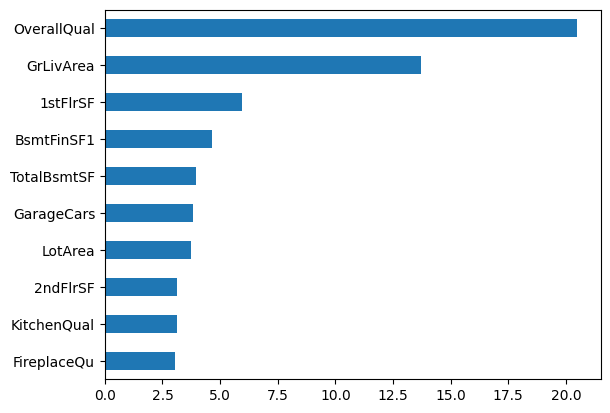

In [ ]:
ar.get_feature_importances().head(10).sort_values().plot.barh()

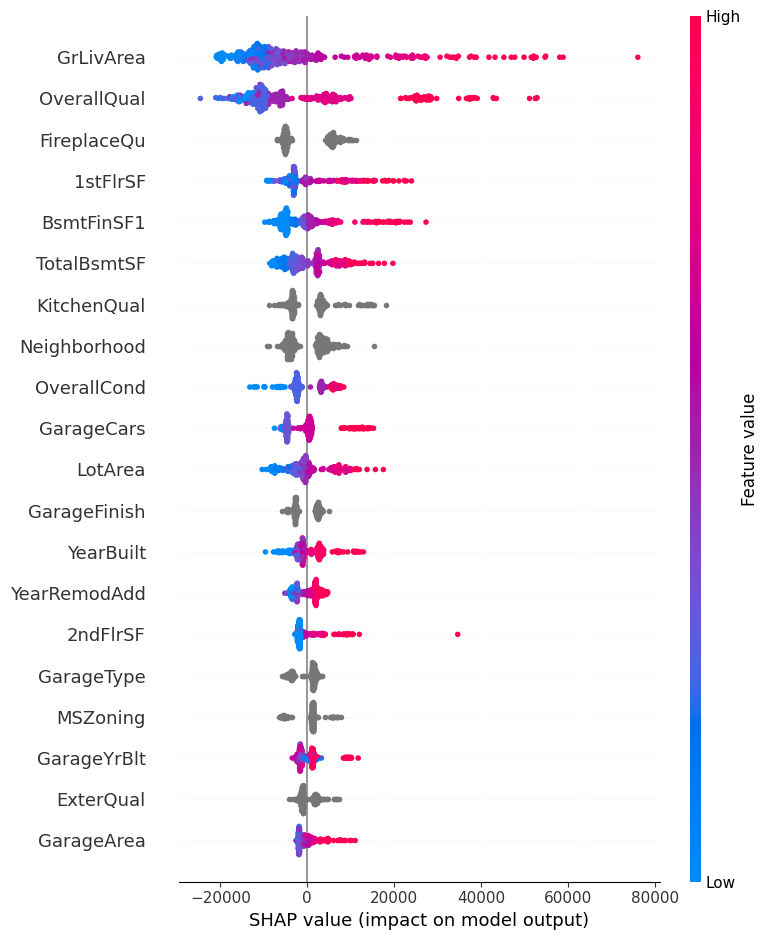

In [ ]:
ar.get_shap()

## CatBoostRegressorCV

In [ ]:
# Concat X_cat and X_num for using in catboost
X_catboost = pd.concat([X_cat, X_num], axis=1)

In [ ]:
X_catboost.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,548,0,61,0,0,0,0,0,2,2008
1,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,460,298,0,0,0,0,0,0,5,2007
2,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,608,0,42,0,0,0,0,0,9,2008
3,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,642,0,35,272,0,0,0,0,2,2006
4,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836,192,84,0,0,0,0,0,12,2008


In [ ]:
cbcv = CatBoostRegressorCV(
    cat_features=list(range(len(cat_cols)))
)
cbcv.fit(X_catboost, y)

CatBoostRegressorCV(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])

In [ ]:
cbcv.score(X_catboost, y)

0.9835889355851075

In [ ]:
cbcv.metrics_

,r2_score,rmse,mape
0,0.907499,26636.677034,0.093462
1,0.934493,21104.525601,0.080070
2,0.708497,40130.504754,0.098265
3,0.886393,26708.645472,0.093434
4,0.925741,19701.295826,0.075160
mean,0.872524,26856.329737,0.088078
std,0.093532,8070.804505,0.009906


In [ ]:
# Predict the target variable for new data
predictions = cbcv.predict(X_catboost)

In [ ]:
# Test CatBoostRegressorCV using AutoRegressor to fill automatically missing values and arrange values automatically
cbcv = CatBoostRegressorCV(
    cat_features=list(range(len(cat_cols)))
)

ar = AutoRegressor(
    num_cols=num_cols,
    cat_cols=cat_cols,
    target_col='SalePrice',
    use_catboost_native_cat_features=True,
    data=data,
    estimator=cbcv,
)

ar.fit_report()

Imputer strategy: SimpleImputer(strategy='median')
Using estimator CatBoostRegressorCV(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])
R2 Score: 0.9125046051539697
RMSE: 24757.469207350325
MAPE: 0.08813980327749088


## RegressorTimeSeriesCV

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RegressorTimeSeriesCV with a base regressor and cross-validation strategy
reg_tscv = RegressorTimeSeriesCV(base_reg=RandomForestRegressor(), cv=5)

# Fit the RegressorTimeSeriesCV to the training data
reg_tscv.fit(X_num, y)
reg_tscv

RegressorTimeSeriesCV(base_reg=RandomForestRegressor())

In [ ]:
reg_tscv.metrics_

,train_size,test_size,train_start_index,train_end_index,test_start_index,test_end_index,r2_score,rmse,mape
0,245,243,0,244,245,487,0.870264,28630.258580,0.117311
1,488,243,0,487,488,730,0.794495,40330.053395,0.132850
2,731,243,0,730,731,973,0.862934,27865.628836,0.102215
3,974,243,0,973,974,1216,0.835772,33497.124956,0.109466
4,1217,243,0,1216,1217,1459,0.800384,32331.165167,0.112466
mean,731,243,0,730,731,973,0.832770,32530.846187,0.114862
std,384,0,0,384,384,384,0.034780,4969.407330,0.011450


## KNNRegressor

In [ ]:
# Initialize the KNNRegressor with specific parameters
knn_reg = KNNRegressor(n_neighbors=3)

# Fit the KNNRegressor to the training data
knn_reg.fit(X_num.values, y)

# Predict the target variable for new data and return the index of the nearest matched neighbor
predictions, nearest_matched_index, neigh_ind = knn_reg.predict(X_num, return_match_index=True, pred_calc='median')

In [ ]:
knn_reg.score(X_num, y)

0.8264707348813984

In [ ]:
predictions

array([208500., 173000., 223500., ..., 256000., 142125., 147500.])

In [ ]:
nearest_matched_index

array([[   0],
       [   1],
       [   2],
       ...,
       [1457],
       [1458],
       [1459]])

In [ ]:
neigh_ind

array([[   0,  212,  256],
       [   1,  395,  186],
       [   2,  280,  222],
       ...,
       [1457, 1171, 1328],
       [1458, 1418, 1259],
       [1459, 1424, 1259]])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()